# Trotter systematic error - Hubbard on the square lattice 

In this example we use the [pyALF](https://git.physik.uni-wuerzburg.de/ALF/pyALF/-/tree/master/) interface to run ALF with the Mz choice of Hubbard-Stratonovich transformation (i.e., coupled to the $z$-component of the spin) on a $6\times 6$ site square lattice, at $U/t=4$ half-band filling, and inverse temperature $\beta t = 5$.

We carry out a systematic $\Delta \tau  t$ extrapolation keeping    $\Delta \tau t  L_\text{Trotter} = 2$  constant. Recall that  the formulation of the auxiliary field QMC approach is based on the symmetric Trotter decomposition 
$$
e^{ -\Delta \tau \left( \hat{A} + \hat{B} \right) }  =  e^{ -\Delta \tau \hat{A}/2}  e^{ -\Delta \tau  \hat{B}  }   e^{ -\Delta \tau \hat{A}/2}  +  \mathcal{O} \left (\Delta  \tau^3\right)
$$
The overall error produced by this approximation is of the order $\Delta \tau^2$.  

Bellow we go through the steps for performing this extrapolation: setting the simulation parameters, running it and analysing the data. A reference plot for this analyses is found in [ALF documentation](https://git.physik.uni-wuerzburg.de/ALF/ALF/-/blob/master/Documentation/doc.pdf), Sec. 2.3.2 (Symmetric Trotter decomposition).

---

**1.** Import `Simulation` class from the `py_alf` python module, which provides the interface with ALF, as well as mathematics and plotting packages:

In [1]:
from py_alf import ALF_source, Simulation # Interface with ALF
# 
import numpy as np                        # Numerical library
from scipy.optimize import curve_fit      # Numerical library
import matplotlib.pyplot as plt           # Plotting library
alf_src = ALF_source(branch='master')    # Obtain ALF source code

Checking out branch master
Your branch is up to date with 'origin/master'.


Already on 'master'


**2.** Create instances of `Simulation`, specifying the necessary parameters, in particular the different $\Delta \tau$ values:

In [2]:
sims = []                                # Vector of Simulation instances
print('dtau values used:')
for dtau in [0.05, 0.1, 0.15]:            # Values of dtau
    print(dtau)
    sim = Simulation(
        alf_src,
        'Hubbard',                       # Hamiltonian
        {                                # Model and simulation parameters for each Simulation instance
        'Model': 'Hubbard',              #    Base model
        'Lattice_type': 'Square',        #    Lattice type
        'L1': 6,                         #    Lattice length in the first unit vector direction
        'L2': 6,                         #    Lattice length in the second unit vector direction
        'Checkerboard': False,           #    Whether checkerboard decomposition is used or not
        'Symm': True,                    #    Whether symmetrization takes place
        'ham_T': 1.0,                    #    Hopping parameter
        'ham_U': 4.0,                    #    Hubbard interaction
        'ham_Tperp': 0.0,                #    For bilayer systems
        'beta': 5.0,                     #    Inverse temperature
        'Ltau': 0,                       #    '1' for time-displaced Green functions; '0' otherwise 
        'NSweep': 100,                   #    Number of sweeps per bin
        'NBin': 10,                      #    Number of bins
        'Dtau': dtau,                    #    Only dtau varies between simulations, Ltrot=beta/Dtau
        'Mz': True,                      #    If true, sets the M_z-Hubbard model: Nf=2, N_sum=1,
        },                               #             HS field couples to z-component of magnetization
    )
    sims.append(sim)

dtau values used:
0.05
0.1
0.15


**3.** Compile ALF, downloading it first if not found locally. This may take a few minutes:

In [3]:
sims[0].compile()                        # Compilation needs to be performed only once

Compiling ALF... 
Cleaning up Prog/
Cleaning up Libraries/
Cleaning up Analysis/
Compiling Libraries


entanglement_mod.F90:35:2:

   35 | #warning "You are compiling entanglement without MPI. No results possible"
      |  1~~~~~~
ar: creating modules_90.a
ar: creating libqrref.a


Compiling Analysis
Compiling Program
Parsing Hamiltonian parameters
filename: Hamiltonians/Hamiltonian_Kondo_smod.F90
filename: Hamiltonians/Hamiltonian_Hubbard_smod.F90
filename: Hamiltonians/Hamiltonian_Hubbard_Plain_Vanilla_smod.F90
filename: Hamiltonians/Hamiltonian_tV_smod.F90
filename: Hamiltonians/Hamiltonian_LRC_smod.F90
filename: Hamiltonians/Hamiltonian_Z2_Matter_smod.F90
Compiling program modules
Link program
Done.


**4.** Perform the simulations, as specified in each element of `sim`:

In [4]:
for i, sim in enumerate(sims):
    sim.run()                            # Perform the actual simulation in ALF

Prepare directory "/home/jonas/Programs/pyALF/Notebooks/ALF_data/Hubbard_Square_L1=6_L2=6_Checkerboard=False_Symm=True_T=1.0_U=4.0_Tperp=0.0_beta=5.0_Dtau=0.05_Mz=True" for Monte Carlo run.
Create new directory.
Run /home/jonas/Programs/ALF/Prog/ALF.out
 ALF Copyright (C) 2016 - 2021 The ALF project contributors
 This Program comes with ABSOLUTELY NO WARRANTY; for details see license.GPL
 This is free software, and you are welcome to redistribute it under certain conditions.
 No initial configuration
Prepare directory "/home/jonas/Programs/pyALF/Notebooks/ALF_data/Hubbard_Square_L1=6_L2=6_Checkerboard=False_Symm=True_T=1.0_U=4.0_Tperp=0.0_beta=5.0_Dtau=0.1_Mz=True" for Monte Carlo run.
Create new directory.
Run /home/jonas/Programs/ALF/Prog/ALF.out
 ALF Copyright (C) 2016 - 2021 The ALF project contributors
 This Program comes with ABSOLUTELY NO WARRANTY; for details see license.GPL
 This is free software, and you are welcome to redistribute it under certain conditions.
 No initial con

**5.** Calculate the internal energies:

In [5]:
ener = np.empty((len(sims), 2))          # Matrix for storing energy values
dtaus = np.empty((len(sims),))           # Matrix for Dtau values, for plotting
for i, sim in enumerate(sims):
    print(sim.sim_dir)                   # Directory containing the simulation output
    sim.analysis()                       # Perform default analysis
    dtaus[i] = sim.sim_dict['Dtau']      # Store Dtau value
    obs = sim.get_obs()
    ener[i] = obs.iloc[0][['Ener_scal0', 'Ener_scal0_err']]  # Store energy value

/home/jonas/Programs/pyALF/Notebooks/ALF_data/Hubbard_Square_L1=6_L2=6_Checkerboard=False_Symm=True_T=1.0_U=4.0_Tperp=0.0_beta=5.0_Dtau=0.05_Mz=True
### Analyzing /home/jonas/Programs/pyALF/Notebooks/ALF_data/Hubbard_Square_L1=6_L2=6_Checkerboard=False_Symm=True_T=1.0_U=4.0_Tperp=0.0_beta=5.0_Dtau=0.05_Mz=True ###
/home/jonas/Programs/pyALF/Notebooks
Scalar observables:
Ener_scal
Kin_scal
Part_scal
Pot_scal
Histogram observables:
Equal time observables:
Den_eq
Green_eq
SpinT_eq
SpinXY_eq
SpinZ_eq
Time displaced observables:
/home/jonas/Programs/pyALF/Notebooks/ALF_data/Hubbard_Square_L1=6_L2=6_Checkerboard=False_Symm=True_T=1.0_U=4.0_Tperp=0.0_beta=5.0_Dtau=0.05_Mz=True
No orbital locations saved.
/home/jonas/Programs/pyALF/Notebooks/ALF_data/Hubbard_Square_L1=6_L2=6_Checkerboard=False_Symm=True_T=1.0_U=4.0_Tperp=0.0_beta=5.0_Dtau=0.1_Mz=True
### Analyzing /home/jonas/Programs/pyALF/Notebooks/ALF_data/Hubbard_Square_L1=6_L2=6_Checkerboard=False_Symm=True_T=1.0_U=4.0_Tperp=0.0_beta=5.0_

In [6]:
print('For Dtau values', dtaus, 'the measured energies are:\n', ener)

For Dtau values [0.05 0.1  0.15] the measured energies are:
 [[-29.75742853   0.08560141]
 [-29.81231535   0.0437549 ]
 [-29.91469593   0.07072682]]


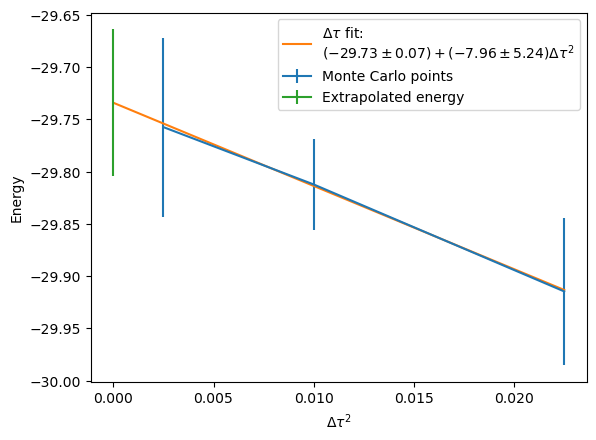

In [7]:
plt.xlabel(r'$\Delta\tau^2$')
plt.ylabel('Energy')
plt.errorbar(dtaus**2, ener[:, 0], ener[:, 1], label='Monte Carlo points')

def func(x, y0, a):
    return y0 + a*x**2
popt1, pcov = curve_fit(func, dtaus, ener[:, 0], sigma=ener[:, 1], absolute_sigma=True)
perr1 = np.sqrt(np.diag(pcov))

xs = np.linspace(0., dtaus.max())
plt.plot(xs**2, func(xs, *popt1), label=r'$\Delta\tau$ fit:''\n'
        f'$({popt1[0]:.2f}\pm{perr1[0]:.2f})+({popt1[1]:.2f}\pm{perr1[1]:.2f})'
        r' \Delta\tau^2$'
        )
plt.errorbar(0, popt1[0], perr1[0], label='Extrapolated energy')
plt.legend()

---
## Exercises
1. Try out the four different combinations for `Checkerboard` and `Symm` settings in order to observe their effect on the output and run time. Reference: Sec. 2.3.2 - Symmetric Trotter decomposition - of the [ALF documentation](https://git.physik.uni-wuerzburg.de/ALF/ALF/-/blob/master/Documentation/doc.pdf), especially Fig. 2.